**Application Of Convolutional Neural Network to image data.**

**Downloading the data**

In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"elmyluka","key":"d42aa70d971e99b18da1b17ef83b9b21"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dogs-vs-cats

100% 812M/812M [00:20<00:00, 42.9MB/s]
100% 812M/812M [00:20<00:00, 41.3MB/s]


In [5]:
!unzip -qq dogs-vs-cats.zip

In [6]:
!unzip -qq train.zip

**1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation
sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce
overfitting and improve performance in developing a network that you train from scratch. What
performance did you achieve?**

In [7]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)


# Training has 1000 samples, test has 500 samples and validation has 500 samples.


make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)


Selecting Train, Validation and Test sets


In [8]:
from tensorflow.keras.utils import image_dataset_from_directory

train_data_1 = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_data_1 = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_data_1 = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Create a dataset instance from NumPy array of random numbers of 1000 samples and each sample of vector size 16 and also Batching the data into batches of size 32

In [9]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

batched_data = dataset.batch(32)
for i, element in enumerate(batched_data):
    print(element.shape)
    if i >= 2:
        break


reshaped_data = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_data):
    print(element.shape)
    if i >= 2:
        break

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(16,)
(16,)
(16,)
(32, 16)
(32, 16)
(32, 16)
(4, 4)
(4, 4)
(4, 4)


In [10]:
import keras
for data_batch, labels_batch in train_data_1:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break
     

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Building and Executing the Model.

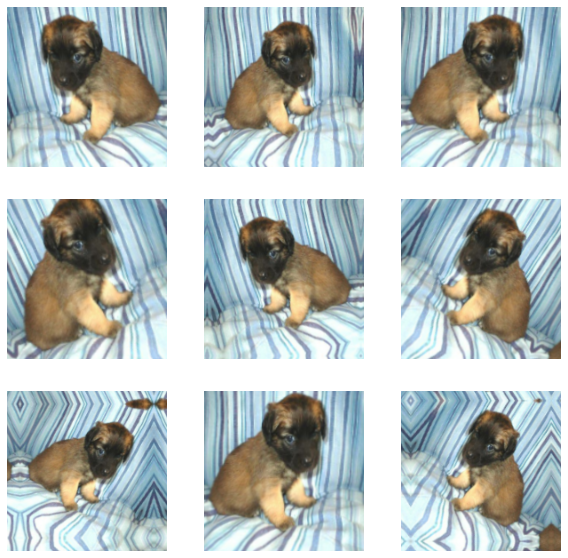

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),])

# Printing Augmented Images of a Random Input Image

plt.figure(figsize=(10, 10))
for images, _ in train_data_1.take(2):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Building Model Structure

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Compiling the Model

In [13]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [14]:
callbacks = [keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True, 
        monitor="val_loss")
]

Training the Model

In [15]:
history = model.fit(
    train_data_1,
    epochs=30,
    validation_data = validation_data_1,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 16s 77ms/step - loss: 0.7047 - accuracy: 0.5075 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 5s 83ms/step - loss: 0.6931 - accuracy: 0.5230 - val_loss: 0.6852 - val_accuracy: 0.5220
Epoch 3/30
63/63 [==============================] - 5s 67ms/step - loss: 0.6902 - accuracy: 0.5360 - val_loss: 0.6757 - val_accuracy: 0.5220
Epoch 4/30
63/63 [==============================] - 4s 66ms/step - loss: 0.6673 - accuracy: 0.5940 - val_loss: 0.6399 - val_accuracy: 0.6400
Epoch 5/30
63/63 [==============================] - 6s 87ms/step - loss: 0.6501 - accuracy: 0.6310 - val_loss: 0.6229 - val_accuracy: 0.6490
Epoch 6/30
63/63 [==============================] - 4s 64ms/step - loss: 0.6228 - accuracy: 0.6745 - val_loss: 0.6261 - val_accuracy: 0.6470
Epoch 7/30
63/63 [==============================] - 5s 71ms/step - loss: 0.6056 - accuracy: 0.7055 - val_loss: 0.5889 - val_accuracy: 0.6800
Epoch 8/30
6

Accuracy and Loss curves plotting

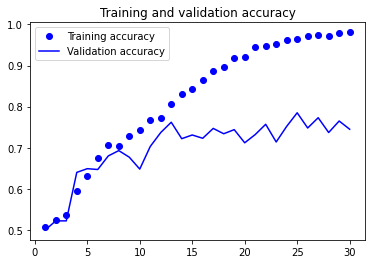

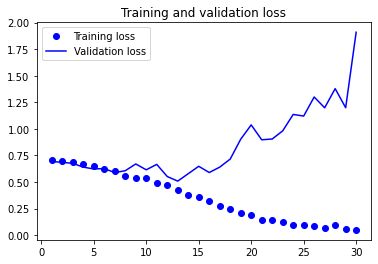

In [16]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Testing the Model and Printing the Output

In [17]:


model.test = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = model.test.evaluate(test_data_1)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 31ms/step - loss: 0.5595 - accuracy: 0.7320
Test accuracy: 0.732


**2. Increase your training sample size. You may pick any amount. Keep the validation and test
samples the same as above. Optimize your network (again training from scratch). What
performance did you achieve?**

In [18]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 1500 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

Data augmentation and plotting augmented images of random Input Image

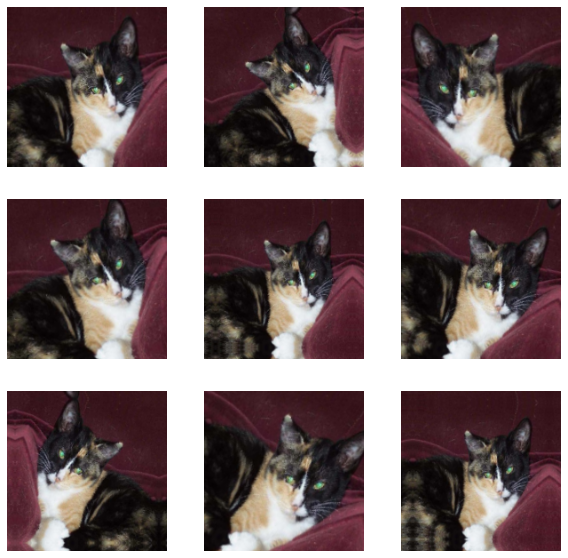

In [19]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_data_1.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Building Model Structure

In [20]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [21]:
from tensorflow import keras
callbacks = [keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]



Training the Model

In [22]:
history = model.fit(
    train_data_1,
    epochs=50,
    validation_data=validation_data_1,
    callbacks=callbacks)

Epoch 1/50


63/63 [==============================] - 20s 218ms/step - loss: 0.6953 - accuracy: 0.5000 - val_loss: 0.6910 - val_accuracy: 0.5410
Epoch 2/50
63/63 [==============================] - 14s 216ms/step - loss: 0.6964 - accuracy: 0.4990 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 14s 221ms/step - loss: 0.6915 - accuracy: 0.5230 - val_loss: 0.6878 - val_accuracy: 0.5310
Epoch 4/50
63/63 [==============================] - 15s 235ms/step - loss: 0.6896 - accuracy: 0.5180 - val_loss: 0.6957 - val_accuracy: 0.5480
Epoch 5/50
63/63 [==============================] - 14s 220ms/step - loss: 0.6863 - accuracy: 0.5350 - val_loss: 0.6932 - val_accuracy: 0.4960
Epoch 6/50
63/63 [==============================] - 14s 218ms/step - loss: 0.6849 - accuracy: 0.5460 - val_loss: 0.6790 - val_accuracy: 0.5880
Epoch 7/50
63/63 [==============================] - 14s 219ms/step - loss: 0.6846 - accuracy: 0.5570 - val_loss: 0.6806 - val_accuracy: 0.5480
Epoch 8/50

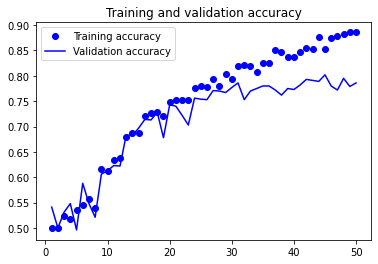

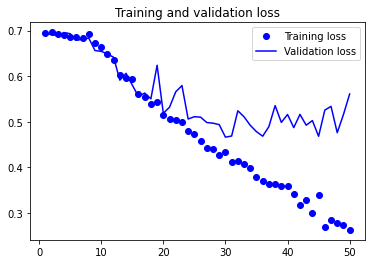

In [23]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [24]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_data_1)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 35ms/step - loss: 0.5260 - accuracy: 0.7650
Test accuracy: 0.765


**3. Now change your training sample so that you achieve better performance than those from Steps
1 and 2. This sample size may be larger, or smaller than those in the previous steps. The
objective is to find the ideal training sample size to get best prediction results.**

Increasing the training sample size to 2000 while maintaining the same validation and test sets as before 500 samples

In [25]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 2000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=2000)
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

Building Model Structure

In [26]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [27]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_data_1,
    epochs=50,
    validation_data=validation_data_1,
    callbacks=callbacks)

Epoch 1/50


63/63 [==============================] - 19s 216ms/step - loss: 0.7005 - accuracy: 0.5075 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 14s 212ms/step - loss: 0.6935 - accuracy: 0.5060 - val_loss: 0.6894 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 14s 213ms/step - loss: 0.6910 - accuracy: 0.5095 - val_loss: 0.6857 - val_accuracy: 0.5580
Epoch 4/50
63/63 [==============================] - 14s 215ms/step - loss: 0.6844 - accuracy: 0.5420 - val_loss: 0.6596 - val_accuracy: 0.6010
Epoch 5/50
63/63 [==============================] - 14s 212ms/step - loss: 0.6847 - accuracy: 0.5310 - val_loss: 0.6801 - val_accuracy: 0.5860
Epoch 6/50
63/63 [==============================] - 14s 211ms/step - loss: 0.6760 - accuracy: 0.5660 - val_loss: 0.6462 - val_accuracy: 0.6200
Epoch 7/50
63/63 [==============================] - 13s 209ms/step - loss: 0.6535 - accuracy: 0.6295 - val_loss: 0.7207 - val_accuracy: 0.5270
Epoch 8/50

Printing Accuracy and Loss Curves

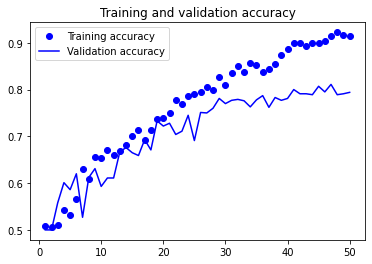

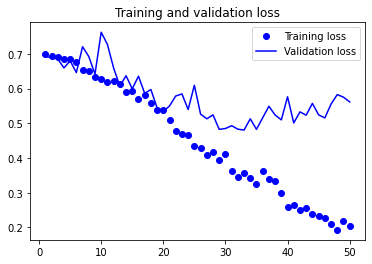

In [28]:


accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [29]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_data_1)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 31ms/step - loss: 0.5285 - accuracy: 0.7750
Test accuracy: 0.775


**4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3
for the pretrained network may be the same or different from those using the network where
you trained from scratch. Again, use any and all optimization techniques to get best
performance.**

Implementing the Model with Training Sample of 2000, Validation & Test Samples of 1000 each and using VGG16 Architecture.

Applying the VGG16 Convolutional Base

In [30]:
from keras.callbacks import EarlyStopping
from keras import regularizers
from tensorflow.keras.utils import image_dataset_from_directory


convolution_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)



58889256/58889256 [==============================] - 2s 0us/step


In [33]:
convolution_base.trainable = True
for layer in convolution_base.layers[:-4]:
    layer.trainable = False

Data Augmentation Stage and a Classifier to the Convolutional Base

In [35]:


data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = convolution_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_pre_trained = keras.Model(inputs, outputs)

Fine-tuning the model


In [36]:

model_pre_trained.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-6),
              metrics=["accuracy"])



Using early stopping to stop optimization 

In [37]:


early_stopping = EarlyStopping(patience=10)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping
]

Training the model

In [46]:
history = model.fit(
    train_data_1,
    epochs=20,
    validation_data = validation_data_1,
    callbacks=callbacks)


Epoch 1/20
63/63 [==============================] - 15s 219ms/step - loss: 0.0579 - accuracy: 0.9735 - val_loss: 0.8618 - val_accuracy: 0.8180
Epoch 2/20
63/63 [==============================] - 13s 209ms/step - loss: 0.0584 - accuracy: 0.9755 - val_loss: 0.9647 - val_accuracy: 0.8030
Epoch 3/20
63/63 [==============================] - 14s 211ms/step - loss: 0.0646 - accuracy: 0.9765 - val_loss: 0.9876 - val_accuracy: 0.7910
Epoch 4/20
63/63 [==============================] - 13s 211ms/step - loss: 0.0852 - accuracy: 0.9660 - val_loss: 1.0305 - val_accuracy: 0.7830
Epoch 5/20
63/63 [==============================] - 13s 210ms/step - loss: 0.0533 - accuracy: 0.9805 - val_loss: 0.9163 - val_accuracy: 0.8130
Epoch 6/20
63/63 [==============================] - 14s 212ms/step - loss: 0.0480 - accuracy: 0.9815 - val_loss: 0.9333 - val_accuracy: 0.8140
Epoch 7/20
63/63 [==============================] - 13s 211ms/step - loss: 0.0557 - accuracy: 0.9800 - val_loss: 1.0019 - val_accuracy: 0.7900

Executing and Printing the Model Output

In [47]:


test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_data_1)
print(f"Test accuracy: {test_acc:.3f}")
     

32/32 [==============================] - 1s 31ms/step - loss: 0.5914 - accuracy: 0.7940
Test accuracy: 0.794


The above outputs of three models built from scratch show that increasing the training sample size increases model accuracy. This demonstrates that more data is always beneficial for increasing data training and thus improving accuracy.